In [14]:
# Install required packages.
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from tqdm import tqdm

os.environ['TORCH'] = torch.__version__
print(torch.__version__)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Helper function for visualization.
import matplotlib.pyplot as plt
import numpy as np

from models.utils import *
from models.data_utils.utils import get_gridX
from models.data_utils.transform import *
from models.data_utils.dataset import FoamDataset
from models.model import GraphTransformer


2.4.1+cu121


In [2]:
hyperparameters = {
    'nfeat_node': 1, # data.x.shape[1],
    'nfeat_edge': 2, # data.edge_attr.shape[1],
    'gnn_dim': 128,
    'gnn_layers': 3,
    'transformer_dim': 256,
    'transformer_layers': 4,
    'transformer_heads': 8,
    'hidden_dim': 512,
    'output_dim': 256,
    'embedding_dim': 32,
    'pos_dim': 3,# data.pos.shape[1],
    'dropout': 0.1,
    'gnn_type': 'GCNConv',
    'pool' : 'cls', 
    'patch_rw_dim': 16,

    'num_epochs': 3000,
    'lr': 1e-4,
    'gamma': 0.9,
    'step_size': 500,
    'batch_size': 16,
    'num_hops': 1,
    'n_patches': 128
}

In [3]:
pre_transform = GraphPartitionTransform(
    n_patches = hyperparameters['n_patches'],
    metis = True,
    drop_rate = 0.0,
    num_hops = hyperparameters['num_hops'],
    is_directed = False,
    patch_rw_dim = hyperparameters['patch_rw_dim'],
    patch_num_diff = -1
)

In [ ]:
# 示例使用
root_path = "../data/firstpb"
json_file = "config.json"
sizes = [64, 64]

pre_transform = pre_transform

datasets = FoamDataset(root_path, json_file, sizes, 
                        pre_transform=pre_transform, 
                        use_pre_transform=True,
                        # force_reload=False)
                        force_reload=True)

Processing...


Found 255 graph data files.
Transformed 255 datasets.
Size of the dataset: 255


Done!


In [3]:
import plotly.graph_objects as go
import torch

def plot_pyg_graph_interactive(data):
    """
    使用 Plotly 交互式绘制 PyG 图的 3D 结构。
    
    Args:
        data (torch_geometric.data.Data): PyG 数据对象，包含 edge_index, pos 等属性。
    """
    # 检查必要属性
    if not hasattr(data, 'edge_index') or not hasattr(data, 'pos'):
        raise ValueError("Data object must contain 'edge_index' and 'pos' attributes.")
    
    # 提取节点位置和边信息
    pos = data.pos.cpu().numpy()  # 节点的 3D 坐标 (num_nodes, 3)
    edge_index = data.edge_index.cpu().numpy()  # 边索引 (2, num_edges)

    # 绘制边
    edge_x, edge_y, edge_z = [], [], []
    for i in range(edge_index.shape[1]):
        src, tgt = edge_index[:, i]
        x_coords = [pos[src, 0], pos[tgt, 0], None]
        y_coords = [pos[src, 1], pos[tgt, 1], None]
        z_coords = [pos[src, 2], pos[tgt, 2], None]
        edge_x.extend(x_coords)
        edge_y.extend(y_coords)
        edge_z.extend(z_coords)

    edge_trace = go.Scatter3d(
        x=edge_x,
        y=edge_y,
        z=edge_z,
        mode='lines',
        line=dict(
            width=0.5,  # 边线更细
            color='rgba(150,150,150,0.2)'  # 边颜色为浅灰色，透明度为 0.2
        ),
        name='Edges'
    )

    # 绘制节点
    node_x, node_y, node_z = pos[:, 0], pos[:, 1], pos[:, 2]
    node_color = np.arange(pos.shape[0])  # 节点颜色可通过特征值映射

    node_trace = go.Scatter3d(
        x=node_x,
        y=node_y,
        z=node_z,
        mode='markers',
        marker=dict(
            size=8,
            color=node_color,  # 节点颜色可通过特征值映射
            colorscale='Viridis',  # 颜色映射
            colorbar=dict(title="Node Feature"),
            opacity=0.8
        ),
        name='Nodes'
    )

    # 创建布局
    layout = go.Layout(
        title='Interactive 3D Graph',
        showlegend=True,
        scene=dict(
            xaxis=dict(title='X'),
            yaxis=dict(title='Y'),
            zaxis=dict(title='Z')
        )
    )

    # 创建图表
    fig = go.Figure(data=[edge_trace, node_trace], layout=layout)
    fig.show()


In [ ]:
for key in rawdata[0].keys():
    print(key, rawdata[0][key].shape)

plot_pyg_graph_interactive(rawdata[0])


In [5]:
for key in datasets[0].keys():
    print(key, datasets[0][key].shape)

edge_attr torch.Size([950, 2])
x torch.Size([99, 1])
y torch.Size([256])
combined_subgraphs torch.Size([2, 6130])
y_first torch.Size([256])
edge_index torch.Size([2, 950])
subgraphs_batch torch.Size([1049])
pos torch.Size([99, 3])
subgraphs_edges_mapper torch.Size([6130])
patch_pos torch.Size([128, 3])
subgraphs_nodes_mapper torch.Size([1049])
patch_pe torch.Size([128, 16])
mask torch.Size([1, 128])


In [6]:
train_loader = DataLoader(datasets, batch_size=hyperparameters['batch_size'], shuffle=True)

In [7]:
first = next(iter(train_loader))
for key in first.keys():
    print(key, first[key].shape)

edge_attr torch.Size([14892, 2])
x torch.Size([1588, 1])
y torch.Size([4096])
combined_subgraphs torch.Size([2, 95616])
y_first torch.Size([4096])
edge_index torch.Size([2, 14892])
subgraphs_batch torch.Size([16480])
pos torch.Size([1588, 3])
subgraphs_edges_mapper torch.Size([95616])
ptr torch.Size([17])
patch_pos torch.Size([2048, 3])
subgraphs_nodes_mapper torch.Size([16480])
patch_pe torch.Size([2048, 16])
mask torch.Size([16, 128])
batch torch.Size([1588])


In [8]:
graph_transformer = GraphTransformer(
    nfeat_node=hyperparameters['nfeat_node'],
    nfeat_edge=hyperparameters['nfeat_edge'],
    gnn_dim=hyperparameters['gnn_dim'],
    gnn_layers=hyperparameters['gnn_layers'],
    transformer_dim=hyperparameters['transformer_dim'],
    transformer_layers=hyperparameters['transformer_layers'],
    transformer_heads=hyperparameters['transformer_heads'],
    hidden_dim=hyperparameters['hidden_dim'],
    output_dim=hyperparameters['output_dim'],
    embedding_dim=hyperparameters['embedding_dim'],
    pos_dim=hyperparameters['pos_dim'],
    dropout=hyperparameters['dropout'],
    gnn_type=hyperparameters['gnn_type'],
    pool=hyperparameters['pool'],
    patch_rw_dim=hyperparameters['patch_rw_dim']
).to(device)

In [9]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())  # 总参数数量
    return total_params

total_params = count_parameters(graph_transformer)
print(f"Total params: {total_params}, {total_params / 1024 / 1024} M")

Total params: 2877568, 2.7442626953125 M


In [10]:
optimizer = Adam(graph_transformer.parameters(), lr=hyperparameters['lr'])

In [11]:
loss_history = []
import tqdm
num_epochs = 300
with tqdm.tqdm(total=num_epochs) as pbar:
    for epoch in range(num_epochs):
        graph_transformer.train()
        total_loss = 0
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = graph_transformer(data).reshape(-1)
            loss = F.mse_loss(out, data.y-data.y_first)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        epoch_loss = total_loss / len(train_loader)
        loss_history.append(epoch_loss)
        pbar.set_postfix({'loss': f"{epoch_loss:.6f}"})
        pbar.update(1)

100%|██████████| 300/300 [03:21<00:00,  1.49it/s, loss=0.205628]


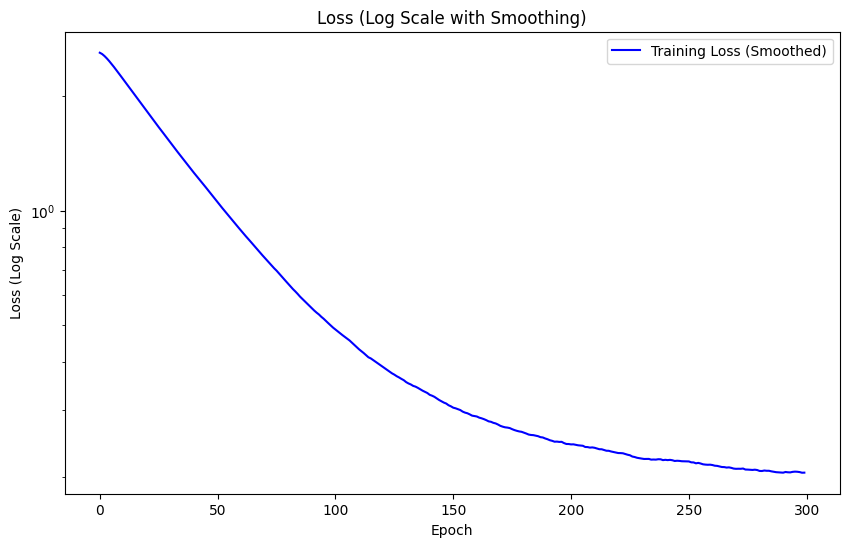

In [12]:
plot_losses(loss_history)

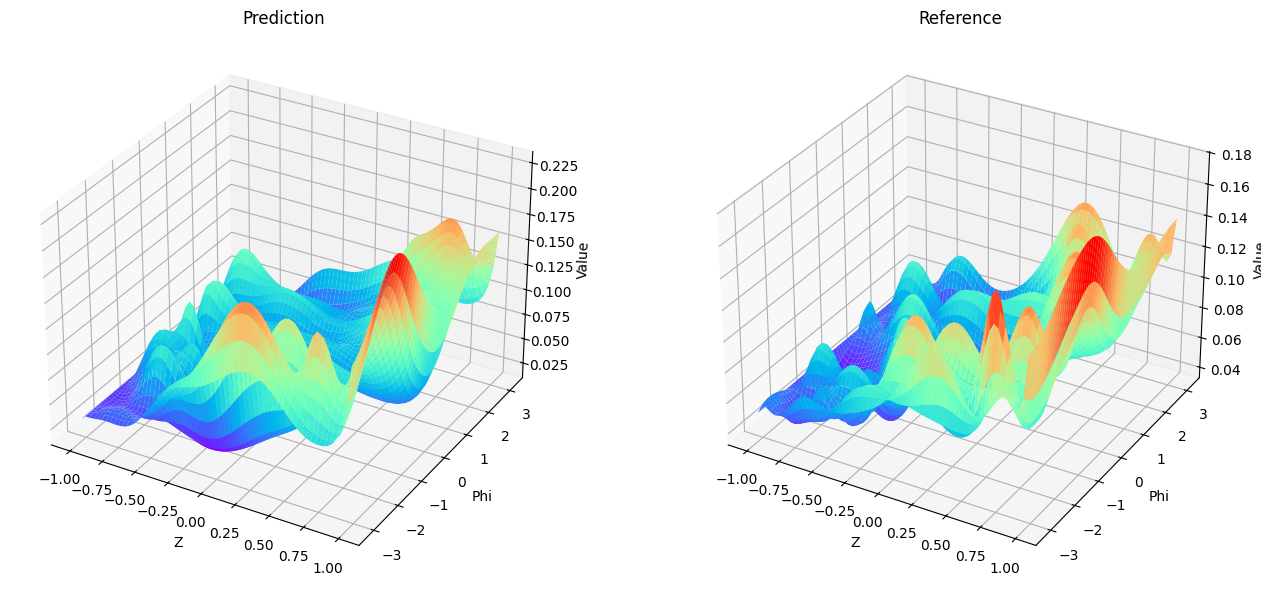

In [13]:
sample = datasets[3]
X = get_gridX(sizes, device=device)
with torch.no_grad():
    graph_transformer.eval()
    weights, mus, kappas = graph_transformer.vmf_param(sample.to(device),is_diff=True)
    img_predict = multi_vmf(weights.squeeze(), mus.squeeze(), kappas.squeeze(), X).cpu().numpy()
    img_predict = img_predict.reshape(sizes)

    tgt_w, tgt_m, tgt_k = extract_param(sample.y)
    img_reference = multi_vmf(tgt_w, tgt_m, tgt_k, X).cpu().numpy()
    img_reference = img_reference.reshape(sizes)
    plot_outputs_3d(img_reference, img_predict, sizes)